In [12]:
import librosa
import librosa.display
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import json
import scipy.signal


In [13]:
recording, sr = librosa.load(
    "/Users/duongtat/Work/_skola/VMM/tmp/7741cf05687b2db615fcef200.wav")
music, sr = librosa.load(
    "/Users/duongtat/Work/_skola/VMM/dataset/REEBOKS OR THE NIKES [fbHxkNa7lhQ].wav")


/opt/homebrew/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


30

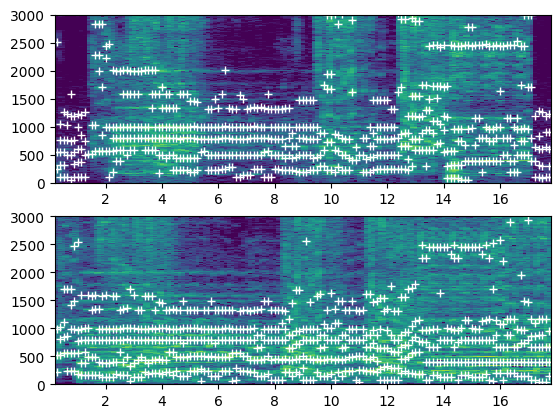

In [72]:

def get_peak_frequencies(y, sr=22_050, n_fft=2_048, hop_length=2_048//4):
    """
    Extract peak frequencies for each FFT frame
    """
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

    all_frames = np.arange(S.shape[1])
    all_bins = np.arange(S.shape[0])

    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    times = librosa.frames_to_time(
        all_frames, sr=sr, n_fft=n_fft, hop_length=hop_length)

    S_out = np.zeros_like(S, dtype=np.bool8)

    result = []
    for time_bin, window in enumerate(S.T):
        peaks, props = scipy.signal.find_peaks(
            window, prominence=0, distance=100)

        num_peaks = min(peaks.shape[-1], 5)
        freq_bins = peaks[
            np.argpartition(props["prominences"], -num_peaks)[-num_peaks:]]

        S_out[freq_bins, time_bin] = True

    result = np.apply_along_axis(
        lambda key: np.array(
            [frequencies[key[0]], times[key[1]]]
        ),
        1,
        np.argwhere(S_out > 0)
    )

    result = result[result[:, 0].argsort()]
    result = result[result[:, 1].argsort(kind="mergesort")]

    return result


def get_hashes_from_peaks(peaks, window_size=3):
    """
    Constructs a sliding window to create a cluster of frequency peaks
    Resulting tuple / hash will have more entropy, thus reducing the computation cost
    """
    flat = np.apply_along_axis(
        lambda key: {"freq": key[0], "time": key[1]}, 1, peaks)

    hashes = []
    for window in np.lib.stride_tricks.sliding_window_view(flat, window_size):
        time = window[0]["time"]
        hash = ",".join([str(int(item["freq"])) for item in window])

        hashes.append({"time": time, "hash": hash})

    return hashes


def compare_fingerprints(music_hashes, record_hashes):
    """
    Figure out matches
    1) Create a fingerprint from recording
    2) Find the intersection of 2 fingerprints based on their hashes
    3) Gather all deltas (distance between needle and search), count how many deltas are matching => sort by number of matching deltas
    """
    # Construct dict from music hashes
    db = defaultdict(list)

    for music in music_hashes:
        db[music["hash"]].append(music["time"])

    durations = defaultdict(int)
    for record in record_hashes:
        for music_time in db[record["hash"]]:
            delta = abs(music_time - record["time"])
            durations[str(delta)] += 1

    if (len(durations) == 0):
        return 0
    return sorted(durations.values())[-1]


def draw_filtered(music, fig=plt):

    n_fft = 11_025
    hop_length = n_fft // 4

    f = get_peak_frequencies(music,
                             n_fft=n_fft,
                             hop_length=hop_length
                             )
    S = np.abs(librosa.stft(
        music,
        n_fft=n_fft,
        hop_length=hop_length,
    ))

    all_frames = np.arange(S.shape[1])
    frequencies = librosa.fft_frequencies(sr=22_050, n_fft=n_fft)

    times = librosa.frames_to_time(
        all_frames, sr=22_050, hop_length=hop_length, n_fft=n_fft)

    fig.pcolormesh(times, frequencies, librosa.amplitude_to_db(S))
    fig.scatter(x=f[:, 1], y=f[:, 0], c="w", marker="+", linewidths=1)
    fig.set_ylim(0, 3000)


fig, ax = plt.subplots(2, 1)

draw_filtered(recording, fig=ax[0])
draw_filtered(music[:recording.shape[-1]], fig=ax[1])

music_hash = get_hashes_from_peaks(get_peak_frequencies(music))
recording_hash = get_hashes_from_peaks(
    get_peak_frequencies(recording))

compare_fingerprints(music_hash, recording_hash)


6

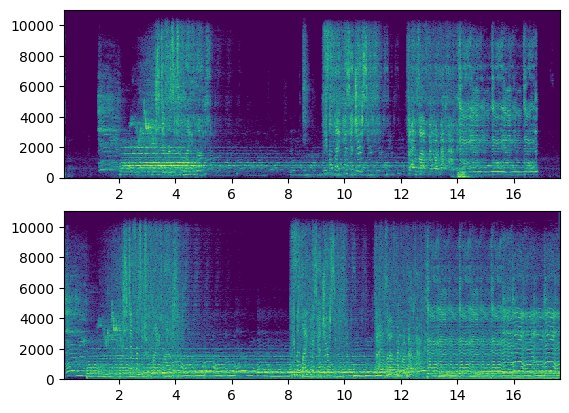

In [46]:
def draw_filtered(music, fig=plt):
    # f = get_peak_frequencies(music)
    S = np.abs(librosa.stft(music, n_fft=2_048, win_length=2_048))

    all_frames = np.arange(S.shape[1])
    frequencies = librosa.fft_frequencies(sr=22_050, n_fft=2_048)
    times = librosa.frames_to_time(all_frames, n_fft=2_048)

    fig.pcolormesh(times, frequencies, librosa.amplitude_to_db(S))
    # fig.scatter(x=f[:, 1], y=f[:, 0], c="w", marker="+", linewidths=1)

    # for i in range(len(LIMITS) - 1):
    #     fig.axhline(y=frequencies[int(LIMITS[i])], c="k")


fig, ax = plt.subplots(2, 1)

draw_filtered(recording, fig=ax[0])
draw_filtered(music[:recording.shape[-1]], fig=ax[1])

music_hash = get_hashes_from_peaks(get_peak_frequencies(music))
recording_hash = get_hashes_from_peaks(
    get_peak_frequencies(recording))

compare_fingerprints(music_hash, recording_hash)
